# Streamflow Predictions for a HUC Region

This notebook demonstrates how to fetch streamflow prediction values for all the streams inside a given hydrologic region. In this example we use the Mid-Atlantic Region HUC-2.

In [79]:
from pynhd.pynhd import NHD, NHDPlusHR, WaterData
from shapely.geometry import Polygon, MultiLineString
import s3fs
import xarray as xr

from datetime import datetime

Get the shape for the Mid-Atlantic Region HUC-2

CPU times: user 928 ms, sys: 43.3 ms, total: 971 ms
Wall time: 934 ms


<AxesSubplot:>

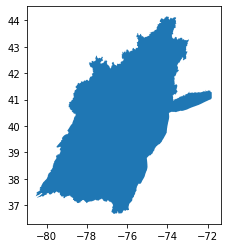

In [80]:
%%time

huc10 = WaterData('wbd02_20201006').byid('huc2', '02')
huc10.geometry.plot()

Get flowlines contained within that shape. There are more than 22K flowlines within the Mid-Atlantic Region.

CPU times: user 32.4 s, sys: 2.52 s, total: 35 s
Wall time: 3min 8s


<AxesSubplot:>

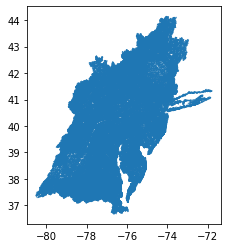

In [81]:
%%time

flowlines = NHD('flowline_mr').bygeom(huc10.geometry[0].geoms[0])
flowlines.plot()

Get the most recent NWM Short Term Forecast day

In [82]:
%%time

fs = s3fs.S3FileSystem(anon=True)
today = datetime.now().strftime('%Y%m%d')

netcdf_url = f's3://noaa-nwm-pds/nwm.{today}/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'

ds = xr.open_dataset(fs.open(netcdf_url), engine='h5netcdf')

CPU times: user 117 ms, sys: 7.25 ms, total: 125 ms
Wall time: 278 ms


Subset the dataset to only the streams within the HUC-10. Also, pick the first forecast for the day.

In [83]:
%%time

nhd_reaches = set([int(f) for f in flowlines['COMID']])
nwm_reaches = set(ds.feature_id.values)

common_reaches = list(set(nwm_reaches).intersection(set(nhd_reaches)))

sub_ds = ds.sel(feature_id=common_reaches, time=f'{today}T01:00:00')

CPU times: user 927 ms, sys: 192 ms, total: 1.12 s
Wall time: 1.12 s


Join the NWM streamflow forecast with the NHD flowlines, and visualize it

In [84]:
%%time

joined = flowlines.merge(sub_ds['streamflow'].to_dataframe(), left_on='COMID', right_on='feature_id')

CPU times: user 740 ms, sys: 32.4 ms, total: 773 ms
Wall time: 771 ms


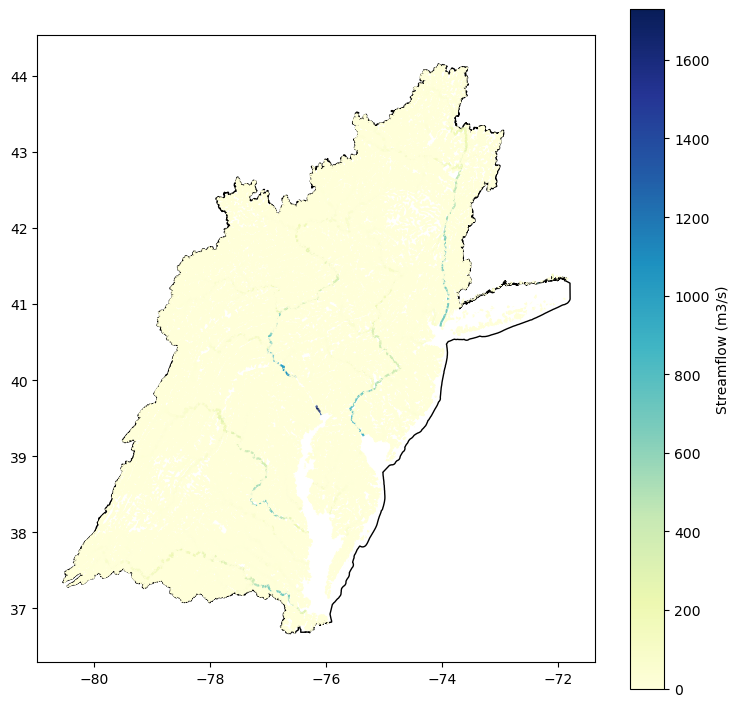

In [85]:
ax = huc10.plot(facecolor="none", edgecolor="k", figsize=(9, 9))
joined.plot(ax=ax, column="streamflow", cmap="YlGnBu", legend=True, legend_kwds={"label": "Streamflow (m3/s)"})
ax.figure.set_dpi(100)